<h1><strong><u>Assignment 5</u></strong></h1>

In [95]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB, CategoricalNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import spacy


<h2><u>Data Preprocessing</u></h2>

In [75]:
df = pd.DataFrame(columns=["title", "target"])

In [76]:
# Formatting text files
titles = []
targets = []
file_path_dict = {'clickbait': './clickbait_data.txt', 'non clickbait': './non_clickbait_data.txt'}
for key, value in file_path_dict.items():
    with open(value, 'r') as file:
        for line_number, line in enumerate(file):
            line = line.strip()
            if line != "":
                titles.append(line)
                targets.append(key)
data_dict = {"title": titles, "target": targets}
df = pd.DataFrame(data_dict)


In [77]:
data = df.sample(frac=1, random_state=42).reset_index(drop=True)
display(data)

,title,target
0,Filipino activist arrested for disrupting Mani...,non clickbait
1,"International Board fixes soccer field size, h...",non clickbait
2,24 Rules For Women On A First Date With A Man,clickbait
3,Political fallout from the sacking of Professo...,non clickbait
4,"Which ""Clueless"" Character Are You Based On Yo...",clickbait
...,...,...
31995,Rocket strike near hotel in Afghan capital inj...,non clickbait
31996,How Well Do You Remember The First Episode Of ...,clickbait
31997,16 Photos From The Delhi Queer Pride Parade Th...,clickbait
31998,33 Of The Most Canadian Sentences Ever,clickbait


In [78]:
X = data.drop("target", axis=1)
y = data["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
display(X_train.shape) 
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(25600, 1)

(6400, 1)

(25600,)

(6400,)

<h2><u>Data Vectorization</u></h2>

In [79]:
nlp = spacy.load("en_core_web_sm")
def custom_spacy_tokenizer(text):
        doc = nlp(text)
        return [token.lemma_.lower().strip() for token in doc if not token.is_stop and not token.is_punct]

In [80]:
tdidf_vectorizer = TfidfVectorizer(tokenizer=custom_spacy_tokenizer)
X_train_tfidf_vectorized = tdidf_vectorizer.fit_transform(X_train['title'])
tdidf_vectorizer.get_feature_names_out()
X_test_tfidf_vectorized = tdidf_vectorizer.transform(X_test['title'])

/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [81]:
display(X_train_tfidf_vectorized.shape)
display(X_test_tfidf_vectorized.shape)

(25600, 16910)

(6400, 16910)

<h2><strong><u>Main Model Selection by Cross Validation Testing</u></strong></h2>

<h3><strong><u>K-Nearest Neighbors Model Selection</u></strong></h3>

<h4><u>Cross Validation Testing</u></h4>

In [82]:
pipeline = Pipeline(
    [
        ("clf", KNeighborsClassifier())
    ]
)
param_grid = {
    "clf__n_neighbors": [51, 53, 55, 57, 59],
    "clf__weights": ["uniform", "distance"]
}

model = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
model.fit(X_train_tfidf_vectorized, y_train)
model.best_params_

{'clf__n_neighbors': 53, 'clf__weights': 'distance'}

In [83]:
knn_classifier = KNeighborsClassifier(n_neighbors=53, weights='distance')
knn_classifier.fit(X_train_tfidf_vectorized, y_train)

KNeighborsClassifier(n_neighbors=53, weights='distance')

In [84]:
metrics = {'Accuracy': 'accuracy', 'Precision (Macro)': 'precision_macro', 'Recall (Macro)': 'recall_macro'}

<h4><u>K-Nearest Neighbors Training Metrics</u></h4>

In [88]:
for key, value in metrics.items():
    knn_training_values = cross_val_score(knn_classifier, X_train_tfidf_vectorized, y_train, scoring=value, cv=5)
    print(f"Cross-validation {key} training scores: ", knn_training_values)
    np_knn_training_values = np.array(knn_training_values)
    average = np.mean(np_knn_training_values)
    stDev = np.std(np_knn_training_values)
    print(average.round(2), " +/- ", stDev.round(4), "\n")

Cross-validation Accuracy training scores:  [0.92285156 0.91367188 0.91464844 0.91875    0.91875   ]
0.92  +/-  0.0033 

Cross-validation Precision (Macro) training scores:  [0.9266564  0.91870899 0.91943138 0.9224119  0.92398081]
0.92  +/-  0.0029 

Cross-validation Recall (Macro) training scores:  [0.92290707 0.9137363  0.91473215 0.91882304 0.91883708]
0.92  +/-  0.0033 



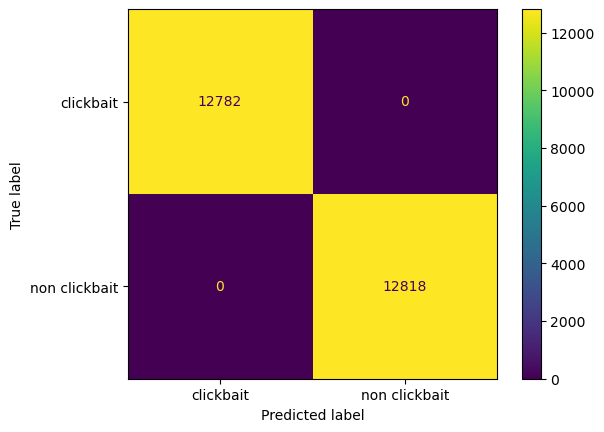

In [89]:
#Training Confusion Matrix
ConfusionMatrixDisplay.from_estimator(knn_classifier, X_train_tfidf_vectorized, y_train)

<h4><u>K-Nearest Neighbors Testing Metrics</u></h4>

In [90]:
for key, value in metrics.items():
    knn_training_values = cross_val_score(knn_classifier, X_test_tfidf_vectorized, y_test, scoring=value, cv=5)
    print(f"Cross-validation {key} training scores: ", knn_training_values)
    np_knn_training_values = np.array(knn_training_values)
    average = np.mean(np_knn_training_values)
    stDev = np.std(np_knn_training_values)
    print(average.round(2), " +/- ", stDev.round(4), "\n")

Cross-validation Accuracy training scores:  [0.89765625 0.88125    0.896875   0.9        0.90546875]
0.9  +/-  0.0081 

Cross-validation Precision (Macro) training scores:  [0.90577028 0.89067526 0.90212266 0.90444844 0.91039919]
0.9  +/-  0.0066 

Cross-validation Recall (Macro) training scores:  [0.89721766 0.88076683 0.89660906 0.8997561  0.90521398]
0.9  +/-  0.0082 



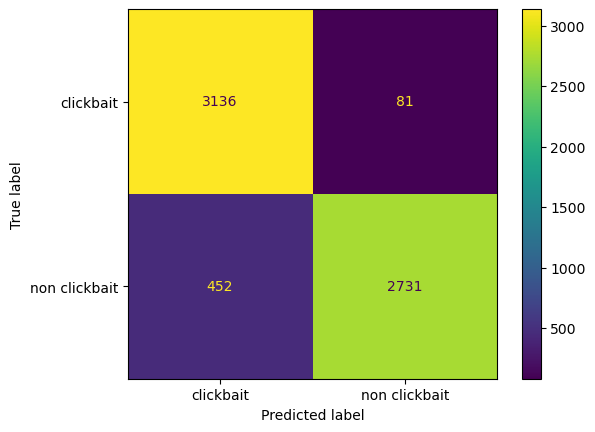

In [ ]:
#Testing Confusion Matrix
ConfusionMatrixDisplay.from_estimator(knn_classifier, X_test_tfidf_vectorized, y_test)

<h4><u>K-Nearest Neighbors Learning Curves</u></h4>

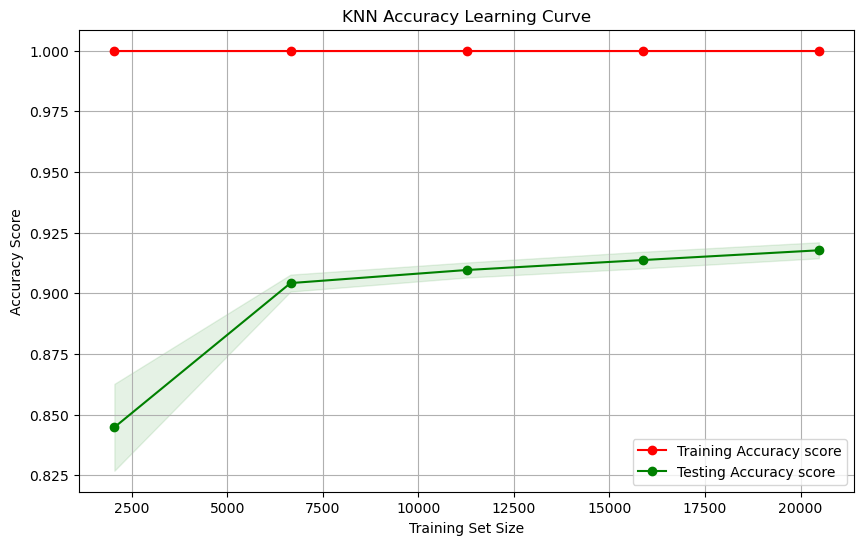

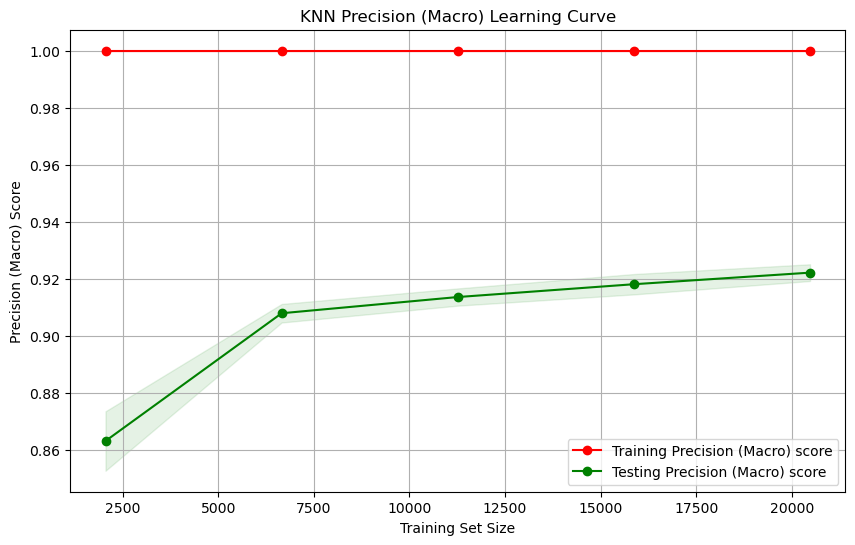

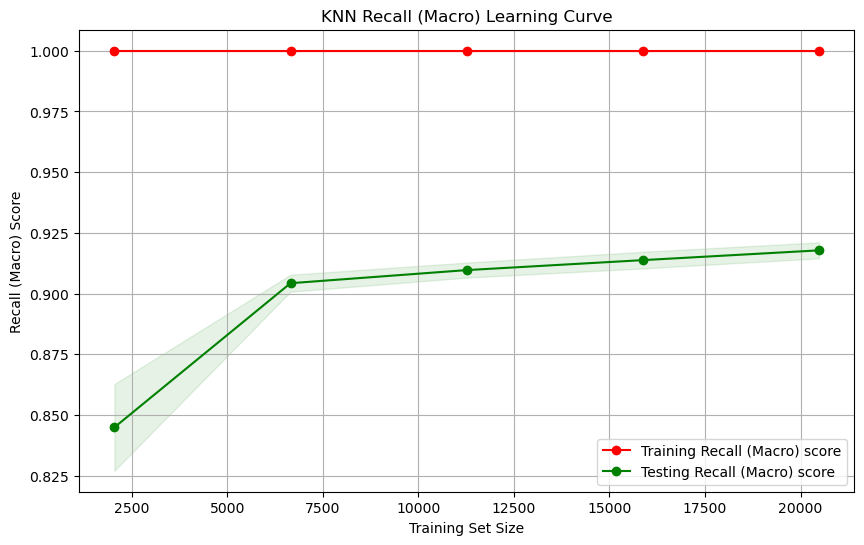

Exception ignored in: <function ResourceTracker.__del__ at 0x106ee5bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102b39bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x105449bc0>
Traceback (most recent call last

In [ ]:
for key, value in metrics.items():
    knn_train_sizes, knn_train_scores, knn_test_scores = learning_curve(
        knn_classifier,
        X_train_tfidf_vectorized,
        y_train,
        cv=5,  # Number of folds for cross-validation
        scoring=value,  # Metric to evaluate the model
        n_jobs=-1,  # Use all available CPU cores
    )

    # Calculate mean and standard deviation for scores
    knn_train_scores_mean = np.mean(knn_train_scores, axis=1)
    knn_train_scores_std = np.std(knn_train_scores, axis=1)
    knn_test_scores_mean = np.mean(knn_test_scores, axis=1)
    knn_test_scores_std = np.std(knn_test_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.title(f"KNN {key} Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel(f"{key} Score")
    plt.grid()

    plt.fill_between(knn_train_sizes, knn_train_scores_mean - knn_train_scores_std,
                    knn_train_scores_mean + knn_train_scores_std, alpha=0.1,
                    color="r")
    plt.fill_between(knn_train_sizes, knn_test_scores_mean - knn_test_scores_std,
                    knn_test_scores_mean + knn_test_scores_std, alpha=0.1,
                    color="g")
    plt.plot(knn_train_sizes, knn_train_scores_mean, 'o-', color="r",
             label=f"Training {key} score")
    plt.plot(knn_train_sizes, knn_test_scores_mean, 'o-', color="g",
             label=f"Testing {key} score")

    plt.legend(loc="best")
    plt.show()

<h3><strong><u>Naive Bayes Model Selection</u></strong></h3>

<h4><u>Cross Validation Testing</u></h4>

In [102]:
pipeline = Pipeline(
    [
        ("clf", None)
    ]
)
param_grid = [
    {"clf": [ComplementNB()], "clf__alpha": [0.05, 0.1, 0.5, 1.0]},
    {"clf": [MultinomialNB()], "clf__alpha": [0.05, 0.1, 0.5, 1.0]},
    {"clf": [GaussianNB()]},
    {"clf": [CategoricalNB()], "clf__alpha": [0.05, 0.1, 0.5, 1.0]},
    {"clf": [BernoulliNB()], "clf__alpha": [0.05, 0.1, 0.5, 1.0]}
    ]

model = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
model.fit(X_train_tfidf_vectorized, y_train)
model.best_params_

/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
25 fits failed out of a total of 85.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.

{'clf': BernoulliNB(), 'clf__alpha': 0.1}

In [103]:
nb_classifier = BernoulliNB(alpha=0.1)
nb_classifier.fit(X_train_tfidf_vectorized, y_train)

BernoulliNB(alpha=0.1)

<h4><u>Naive Bayes Training Metrics</u></h4>

In [104]:
for key, value in metrics.items():
    nb_training_values = cross_val_score(nb_classifier, X_train_tfidf_vectorized, y_train, scoring=value, cv=5)
    print(f"Cross-validation {key} training scores: ", nb_training_values)
    np_nb_training_values = np.array(nb_training_values)
    average = np.mean(np_nb_training_values)
    stDev = np.std(np_nb_training_values)
    print(average.round(2), " +/- ", stDev.round(4), "\n")

Cross-validation Accuracy training scores:  [0.95976562 0.953125   0.96171875 0.95527344 0.95917969]
0.96  +/-  0.0031 

Cross-validation Precision (Macro) training scores:  [0.95976852 0.95312558 0.96174707 0.95527498 0.95923111]
0.96  +/-  0.0032 

Cross-validation Recall (Macro) training scores:  [0.9597674  0.95312448 0.96172537 0.95527546 0.95918844]
0.96  +/-  0.0031 



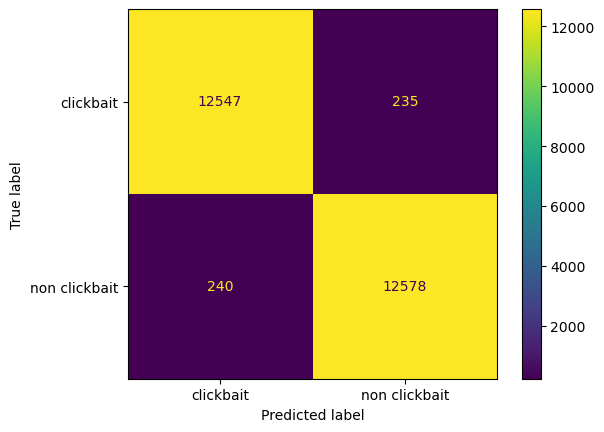

In [105]:
#Training Confusion Matrix
ConfusionMatrixDisplay.from_estimator(nb_classifier, X_train_tfidf_vectorized, y_train)

<h4><u>Naive Bayes Testing Metrics</u></h4>

In [106]:
for key, value in metrics.items():
    nb_training_values = cross_val_score(nb_classifier, X_test_tfidf_vectorized, y_test, scoring=value, cv=5)
    print(f"Cross-validation {key} training scores: ", nb_training_values)
    np_nb_training_values = np.array(nb_training_values)
    average = np.mean(np_nb_training_values)
    stDev = np.std(np_nb_training_values)
    print(average.round(2), " +/- ", stDev.round(4), "\n")

Cross-validation Accuracy training scores:  [0.953125   0.93203125 0.940625   0.9421875  0.95      ]
0.94  +/-  0.0074 

Cross-validation Precision (Macro) training scores:  [0.95355352 0.93345039 0.94062241 0.942242   0.9500282 ]
0.94  +/-  0.0071 

Cross-validation Recall (Macro) training scores:  [0.95303527 0.93185769 0.94063102 0.94216426 0.94998425]
0.94  +/-  0.0075 



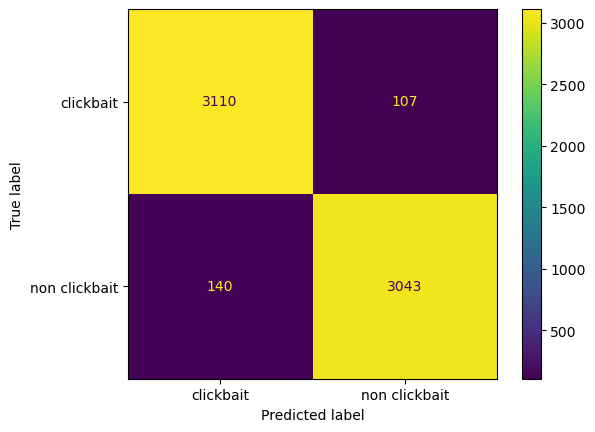

Exception ignored in: <function ResourceTracker.__del__ at 0x10510dbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1050adbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x103101bc0>
Traceback (most recent call last

In [ ]:
#Testing Confusion Matrix
ConfusionMatrixDisplay.from_estimator(nb_classifier, X_test_tfidf_vectorized, y_test)

<h4><u>Naive Bayes Learning Curves</u></h4>

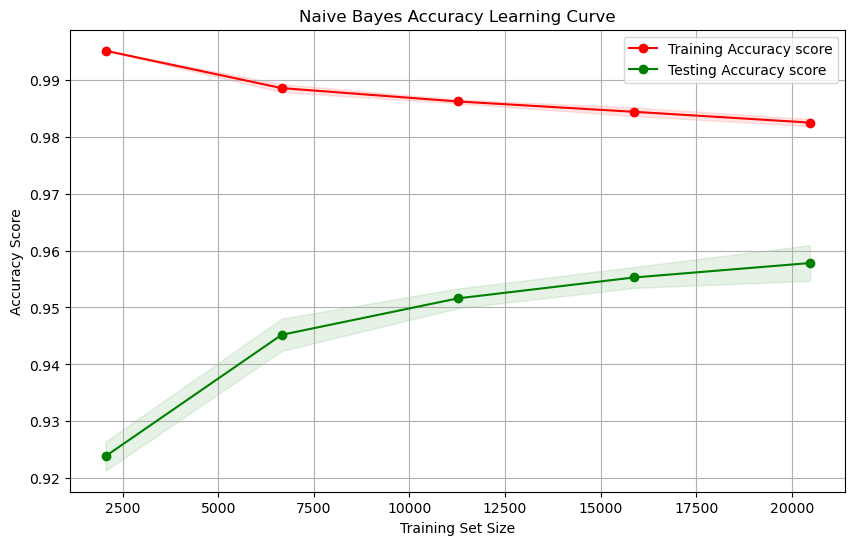

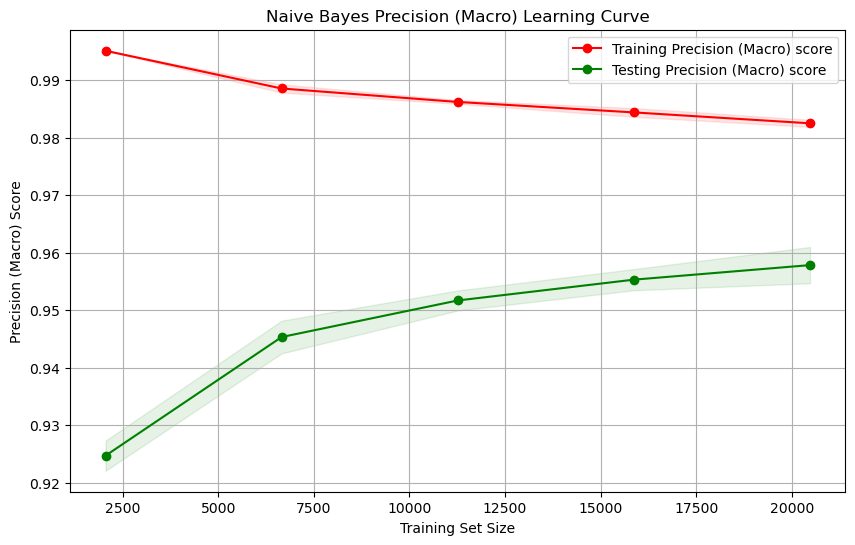

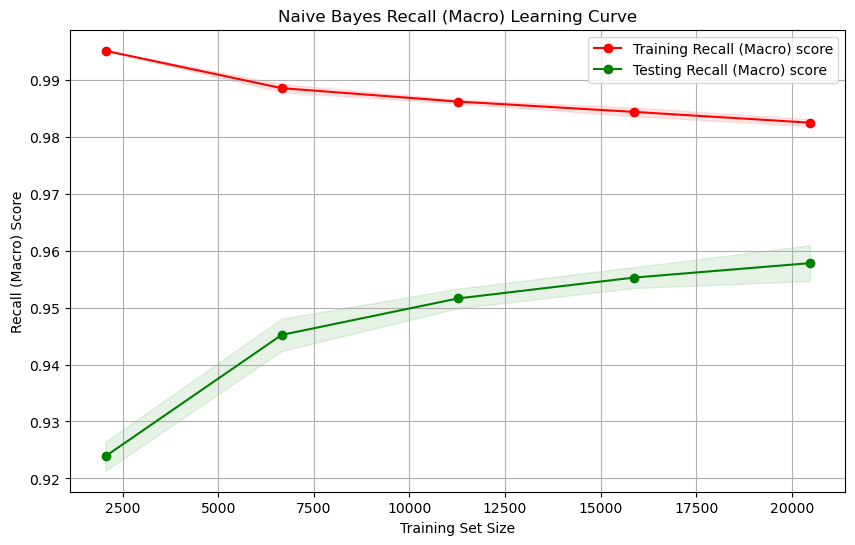

Exception ignored in: <function ResourceTracker.__del__ at 0x106955bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1074fdbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10506dbc0>
Traceback (most recent call last

In [ ]:
for key, value in metrics.items():
    nb_train_sizes, nb_train_scores, nb_test_scores = learning_curve(
        nb_classifier,
        X_train_tfidf_vectorized,
        y_train,
        cv=5,  # Number of folds for cross-validation
        scoring=value,  # Metric to evaluate the model
        n_jobs=-1,  # Use all available CPU cores
    )

    # Calculate mean and standard deviation for scores
    nb_train_scores_mean = np.mean(nb_train_scores, axis=1)
    nb_train_scores_std = np.std(nb_train_scores, axis=1)
    nb_test_scores_mean = np.mean(nb_test_scores, axis=1)
    nb_test_scores_std = np.std(nb_test_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.title(f"Naive Bayes {key} Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel(f"{key} Score")
    plt.grid()

    plt.fill_between(nb_train_sizes, nb_train_scores_mean - nb_train_scores_std,
                    nb_train_scores_mean + nb_train_scores_std, alpha=0.1,
                    color="r")
    plt.fill_between(nb_train_sizes, nb_test_scores_mean - nb_test_scores_std,
                    nb_test_scores_mean + nb_test_scores_std, alpha=0.1,
                    color="g")
    plt.plot(nb_train_sizes, nb_train_scores_mean, 'o-', color="r",
             label=f"Training {key} score")
    plt.plot(nb_train_sizes, nb_test_scores_mean, 'o-', color="g",
             label=f"Testing {key} score")

    plt.legend(loc="best")
    plt.show()